In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import time
import json
import matplotlib.pyplot as plt

In [44]:
# Web scraping the S&P 500 list
def get_symbols(filter=False, criteria=None, value=None):

    # Get a list of S&P500 symbols from Wikipedia based on a filter criteria (GICS Sector, Sub Sector etc.)
    # Returns a list of S&P 500 stock symbol based on your requirements

    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table_id = 'constituents'

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    table_html = soup.find('table', attrs={'id' : table_id}) # S&P 500 companies table on Wiki
    df = pd.read_html(str(table_html))[0]

    if filter == True:
        df_filtered = df[df[criteria] == value]
        symbols = list(df_filtered['Symbol'])
    else:
        symbols = list(df['Symbol'])

    return symbols

# prints the current lists of Financial Companies in S&P 500
top5SandP500 = get_symbols(filter=True, criteria='GICS Sector', value='Financials')[0:5]
print(f'The top 5 S&P 500 Financial Companies are: {top5SandP500}')

The top 5 S&P 500 Financial Companies are: ['AFL', 'ALL', 'AXP', 'AIG', 'AMP']


C:\Users\stephanie\AppData\Local\Temp\ipykernel_2812\2923431058.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html))[0]


In [49]:
# Get the stocks weekly adjusted price data from Alpha Vantage
def GetWeeklyAdjustedPrice(Symbol):
    
    url = 'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_WEEKLY_ADJUSTED',
        'symbol': Symbol, # Initial value
        'outputsize': 'full',
        'apikey': 'MY KEY',
    }
    
    response = requests.get(url, params=params)
    data = response.json()['Weekly Adjusted Time Series']
    
    # Change JSON data to CSV data (more readable)
    df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount'])
    
    for date, values in data.items():
        df.loc[len(df)] = [date, values['1. open'], values['2. high'], values['3. low'], values['4. close'],
                           values['5. adjusted close'], values['6. volume'], values['7. dividend amount']]
        
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df['Company Name'] = Symbol
    
    return df

CompanyOneData = GetWeeklyAdjustedPrice(top5SandP500[0])
CompanyTwoData = GetWeeklyAdjustedPrice(top5SandP500[1])
CompanyThreeData = GetWeeklyAdjustedPrice(top5SandP500[2])
CompanyFourData = GetWeeklyAdjustedPrice(top5SandP500[3])
CompanyFiveData = GetWeeklyAdjustedPrice(top5SandP500[4])

#CompanyFourData

,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Company Name
Date,,,,,,,,
2023-10-03,60.4400,60.5800,58.3500,58.6400,58.6400,5848375,0.0000,AIG
2023-09-29,61.4800,62.4500,60.2200,60.6000,60.6000,13535219,0.0000,AIG
2023-09-22,61.2800,62.9400,60.7600,61.5800,61.5800,15247062,0.0000,AIG
2023-09-15,60.1100,61.3750,59.5900,61.1800,61.1800,17221275,0.3600,AIG
2023-09-08,58.9700,60.1575,58.3200,59.6600,59.3111,11681885,0.0000,AIG
...,...,...,...,...,...,...,...,...
1999-12-10,104.3000,112.9000,102.3000,111.7000,934.3359,11040000,0.0000,AIG
1999-12-03,104.8000,106.5000,102.1000,104.0000,869.9277,12828000,0.0500,AIG
1999-11-26,108.7000,109.2000,104.6000,105.7000,883.7220,6829333,0.0000,AIG


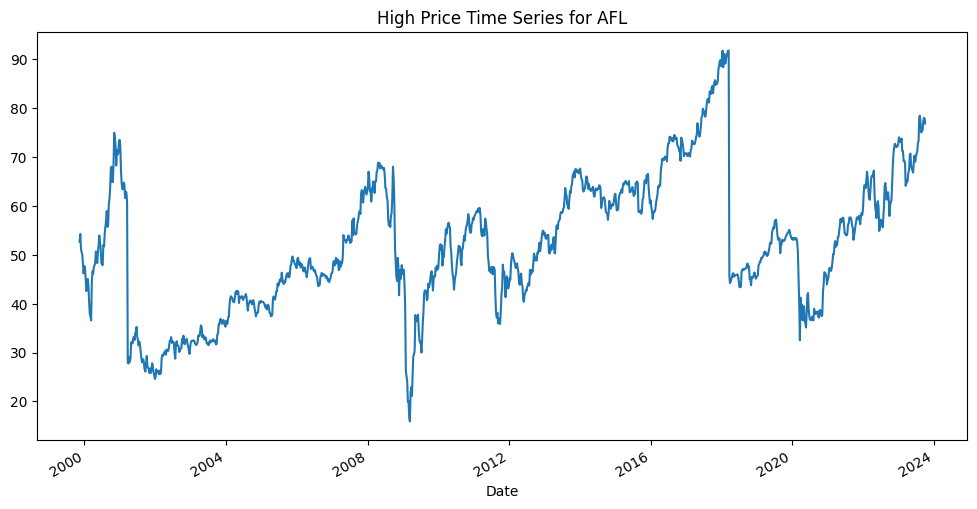

In [71]:
# Create price vs time graph
def PriceTimeSeries(df, price):
    # Sort the DataFrame by the index (Date) in ascending order if not already sorted.
    df = df.sort_index()
    
    # Make sure the data is in the correct data types (float or int).
    # You can convert columns if necessary.
    df[price] = df[price].astype(float)

    # Get company name
    company_name = df['Company Name'].iloc[0]
    
    # Optionally, you can plot the time series to visualize it.
    df[price].plot(figsize=(12, 6))
    plt.title(f'{price} Price Time Series for {company_name}')
    plt.show()


PriceTimeSeries(CompanyOneData, 'High')

Mean Squared Error (MSE): 141.17463252655685
Mean Absolute Error (MAE): 9.385087388828294
R-squared (R2): 0.2384401105232392


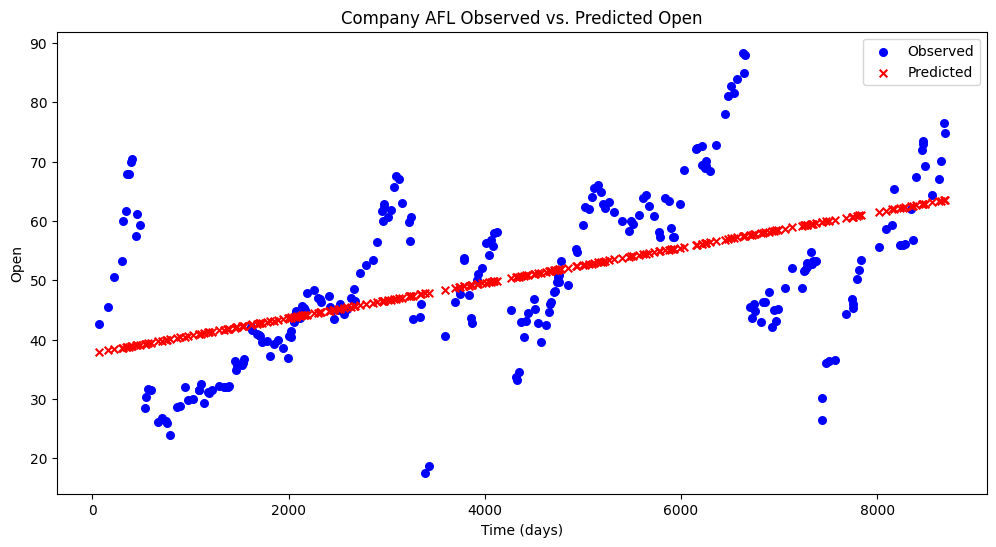

Predicted Open for the future: 63.63121834468777


C:\Users\stephanie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [112]:
def perform_regression(df, target_column, model_type='linear', n_neighbors=5):
    """
    Perform regression analysis on a DataFrame with options for linear or KNN regression.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The name of the target column for prediction.
        model_type (str): The type of regression model ('linear' or 'knn').
        n_neighbors (int): Number of neighbors for KNN regression (default=5).

    Returns:
        None
    """
    # Sort the DataFrame by the index (Date) in ascending order if not already sorted.
    df = df.sort_index()

    # Get company name
    company_name = df['Company Name'].iloc[0]

    # Convert the target column to a numeric data type (float).
    df[target_column] = df[target_column].astype(float)

    # Extract the time (in days) as a numeric feature.
    df['Time'] = (df.index - df.index.min()).days

    # Split the data into features (X) and the target variable (y).
    X = df[['Time']]
    y = df[target_column]

    # Split the data into training and testing sets (e.g., 80% training, 20% testing).
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the regression model.
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'knn':
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    elif model_type == 'svr':
        model = SVR()
    else:
        raise ValueError("Invalid model_type. Supported types are 'linear', 'knn', or 'svr'.")

    model.fit(X_train, y_train)

    # Make predictions on the test data.
    y_pred = model.predict(X_test)

    # Calculate and print regression evaluation metrics.
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R2): {r2}')

    # Plot the observed vs. predicted values.
    plt.figure(figsize=(12, 6))
    plt.scatter(X_test, y_test, label='Observed', color='blue', marker='o', s=30)
    plt.scatter(X_test, y_pred, label='Predicted', color='red', marker='x', s=30)
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel(target_column)
    plt.title(f'Company {company_name} Observed vs. Predicted {target_column}')
    plt.show()

    # Replace the 'future_time' variable with the time (in days) for your future prediction.
    future_time = (datetime(2023, 10, 1) - df.index.min()).days
    future_price = model.predict([[future_time]])
    print(f'Predicted {target_column} for the future: {future_price[0]}')

# Example usage for linear regression:
perform_regression(CompanyOneData, 'Open', model_type='linear')

Mean Squared Error (MSE): 7.652087119999998
Mean Absolute Error (MAE): 1.5720559999999997
R-squared (R2): 0.9916175219608355


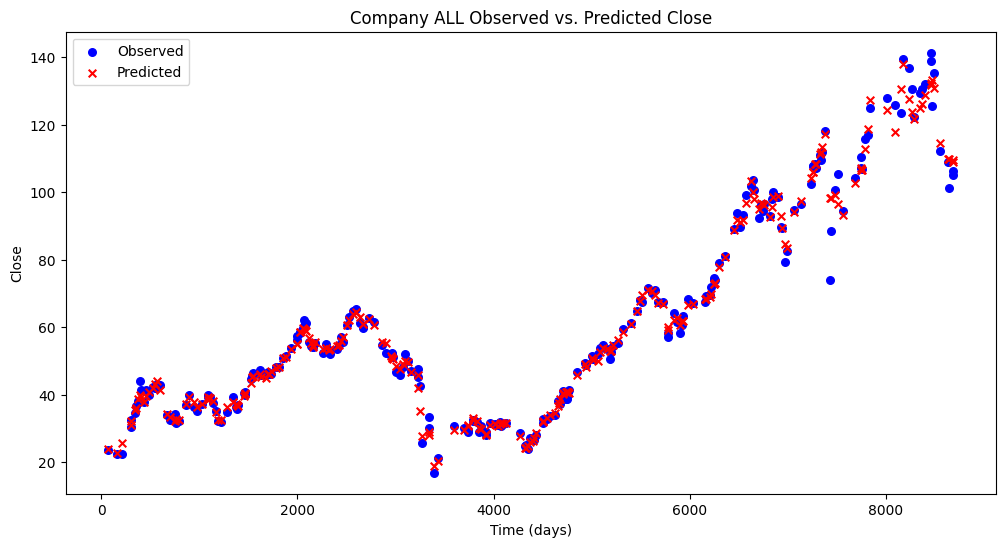

Predicted Close for the future: 110.078


C:\Users\stephanie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [52]:
# Example usage for KNN regression:
perform_regression(CompanyTwoData, 'Close', model_type='knn')

Mean Squared Error (MSE): 150.8838029997525
Mean Absolute Error (MAE): 8.889756379171843
R-squared (R2): 0.5689203816394939


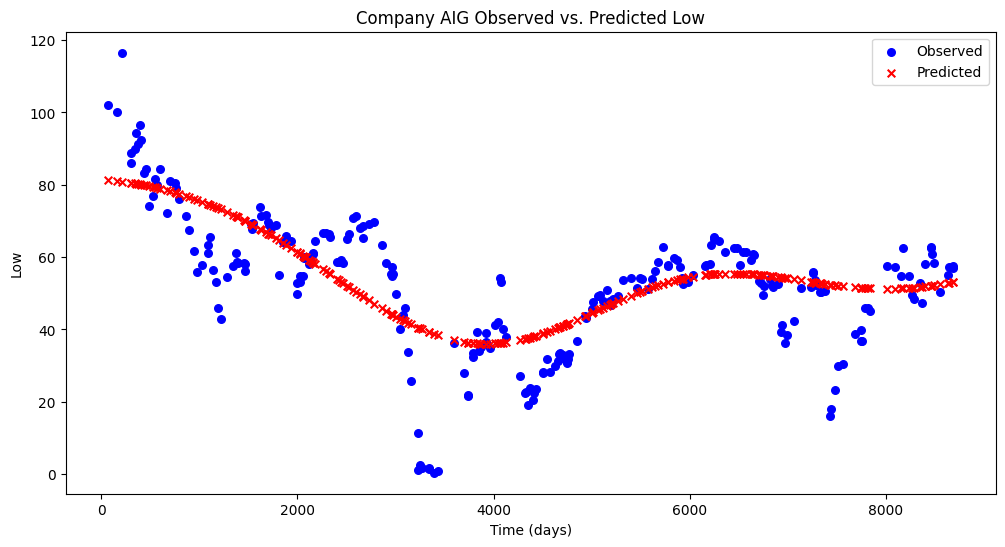

Predicted Low for the future: 53.26174567142495


C:\Users\stephanie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [53]:
# Example usage for KNN regression:
perform_regression(CompanyFourData, 'Low', model_type='svr')